In [78]:
%reload_ext autoreload
%autoreload 2

In [79]:
import numpy as np
from obp.dataset import linear_reward_function
from obp.dataset import (SyntheticBanditDatasetWithActionEmbeds, 
                        linear_reward_function)
from obp.ope import RegressionModel
from ope import run_ope
import pandas as pd
from pandas import DataFrame
from policy import gen_eps_greedy
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from tqdm import tqdm

import conf

from regression_model import RegressionModelMDR

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from plots import plot_line

In [80]:
x = "n_action"
xlabel = "number of actions"

# # fastest
# n_seeds = 4
# n_test = 100
# n_train = 500
# n_actions_list = [10, 20]

# # faster
# n_seeds = 4
# n_test = 1000
# n_train = 5000
# n_actions_list = [10, 20, 50, 100]

# # slower
# n_seeds = 10
# n_test = 1000
# n_train = 5000
# n_actions_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

# # slowest
# n_seeds = 10
# n_test = 1000
# n_train = 10000
# n_actions_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

# slowest
n_seeds = 10
n_test = 1000
n_train = 20000
n_actions_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]



result_df_list = []
for n_action in n_actions_list:
    ## define a dataset class
    # change the list to the action list
    estimated_policy_value_list = []

    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_action,
        dim_context=conf.dim_context,
        beta=conf.beta,
        reward_type=conf.reward_type,
        # Number of categories (cardinality) per each category dimension
        n_cat_per_dim=conf.n_cat_per_dim, 
        latent_param_mat_dim=conf.latent_param_mat_dim, 
        # Number of action/item category dimensions.
        n_cat_dim=conf.n_cat_dim,
        n_unobserved_cat_dim=conf.n_unobserved_cat_dim,
        n_deficient_actions=conf.n_deficient_actions,
        reward_function=conf.reward_function,
        reward_std=conf.reward_std,
        random_state=conf.random_state,
    )
    
    
    ### test bandit data is used to approximate the ground-truth policy value
    test_bandit_data = dataset.obtain_batch_bandit_feedback(
        n_rounds=n_test
        )

    # Generate an evaluation policy via the epsilon-greedy rule
    action_dist_test = gen_eps_greedy(
        expected_reward=test_bandit_data["expected_reward"],
        is_optimal=True,
        eps=conf.eps,
    )

    # actulal policy value e.g., 0.26909277388815384
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_bandit_data["expected_reward"],
        action_dist=action_dist_test,
    )
    
    for _ in tqdm(range(n_seeds), desc = f"n_action: {n_action}"):
        ## generate validation data
        val_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=n_train
            )

        ## make decisions on validation data
        action_dist_val = gen_eps_greedy(
            expected_reward=val_bandit_data["expected_reward"],
            is_optimal=True,
            eps=conf.eps,
        )
        
        # get the estimated values of several estimators e.g., DM, IPS, DR, MIPS
        estimated_policy_values = run_ope(
            dataset=dataset, 
            round = _, 
            # observed data D
            val_bandit_data=val_bandit_data,
            # evaluation policy \pi(a|x)
            action_dist_val=action_dist_val,
            embed_selection=False,
        )
        
        estimated_policy_value_list.append(estimated_policy_values)

    
    
    ## summarize results
    result_df = (
        DataFrame(DataFrame(estimated_policy_value_list).stack())
        .reset_index(1)
        .rename(columns={"level_1": "est", 0: "value"})
    )
    result_df["n_action"] = n_action
    result_df["se"] = (result_df.value - policy_value) ** 2
    result_df["bias"] = 0
    result_df["variance"] = 0
    sample_mean = DataFrame(result_df.groupby(["est"]).mean().value).reset_index()
    for est_ in sample_mean["est"]:
        estimates = result_df.loc[result_df["est"] == est_, "value"].values
        mean_estimates = sample_mean.loc[sample_mean["est"] == est_, "value"].values
        mean_estimates = np.ones_like(estimates) * mean_estimates
        result_df.loc[result_df["est"] == est_, "bias"] = (
            policy_value - mean_estimates
        ) ** 2
        result_df.loc[result_df["est"] == est_, "variance"] = (
            estimates - mean_estimates
        ) ** 2
    result_df_list.append(result_df)


# aggregate all results
result_df = pd.concat(result_df_list).reset_index(level=0)

n_action: 5000: 100%|██████████| 10/10 [3:34:42<00:00, 1288.25s/it] 


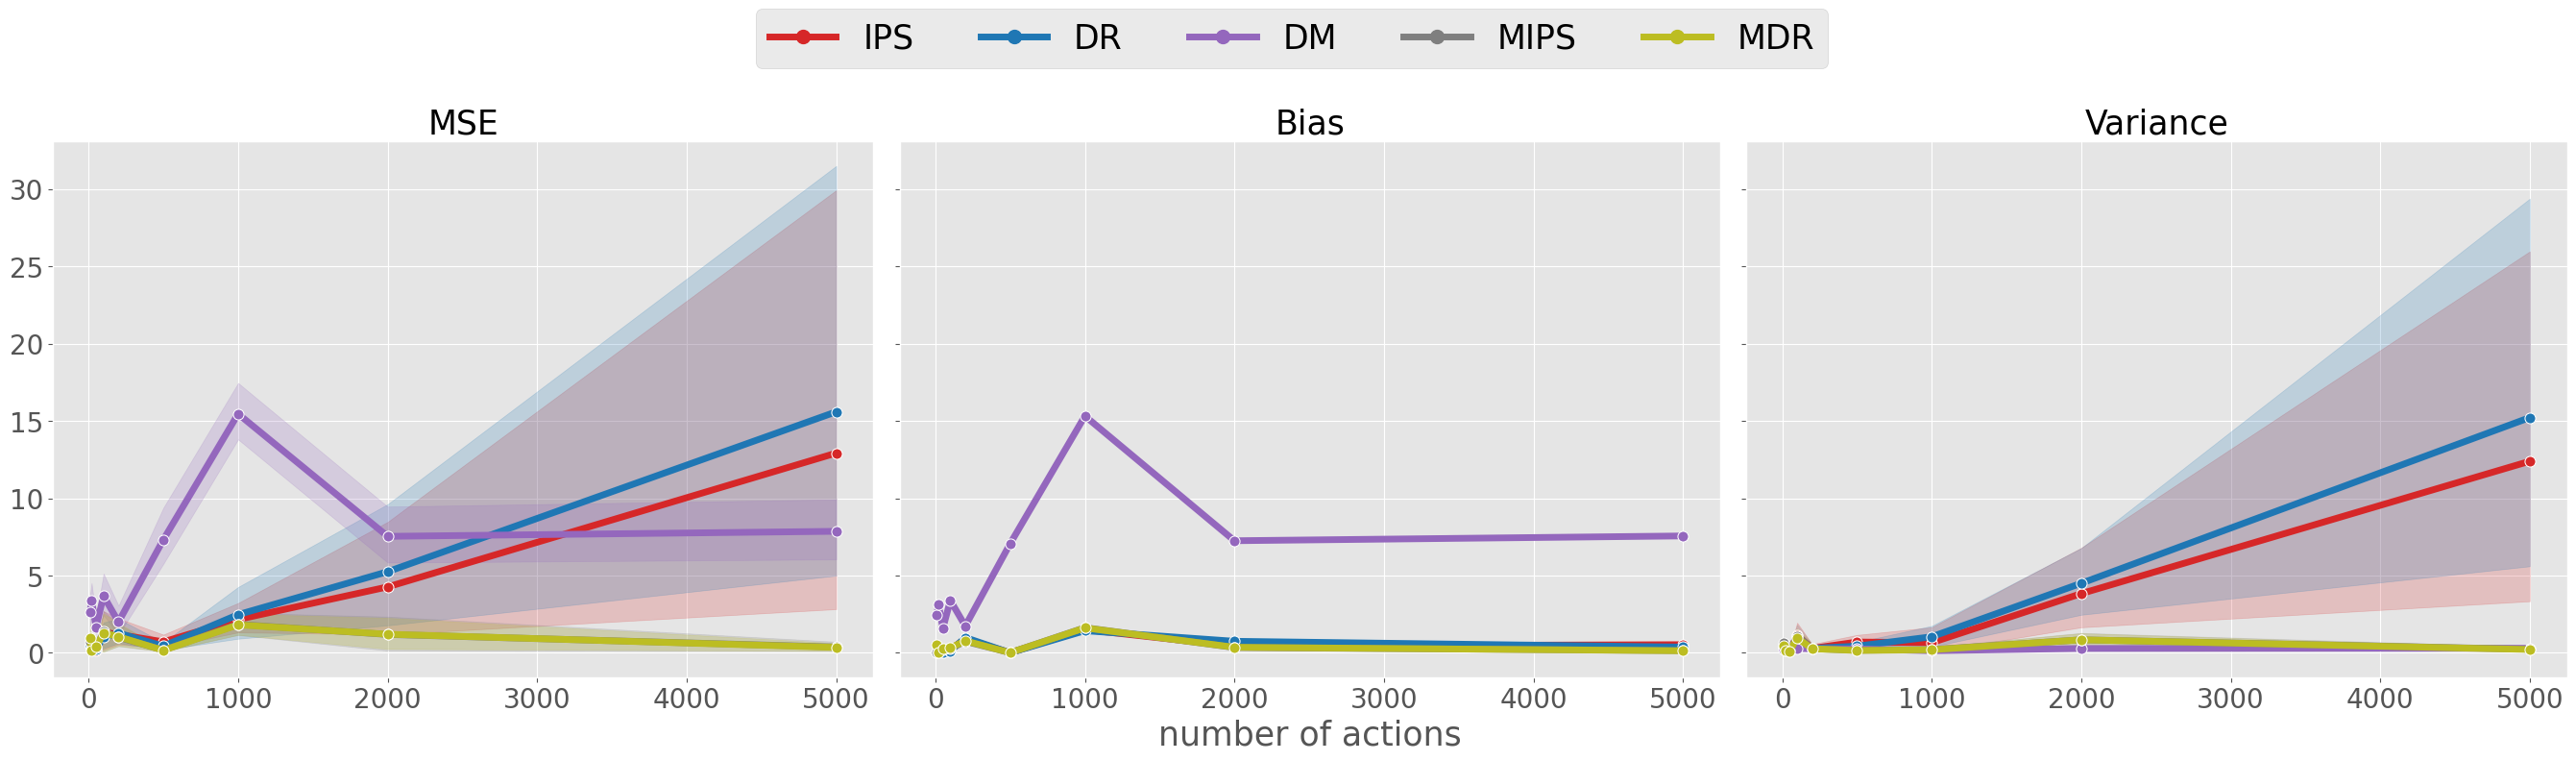

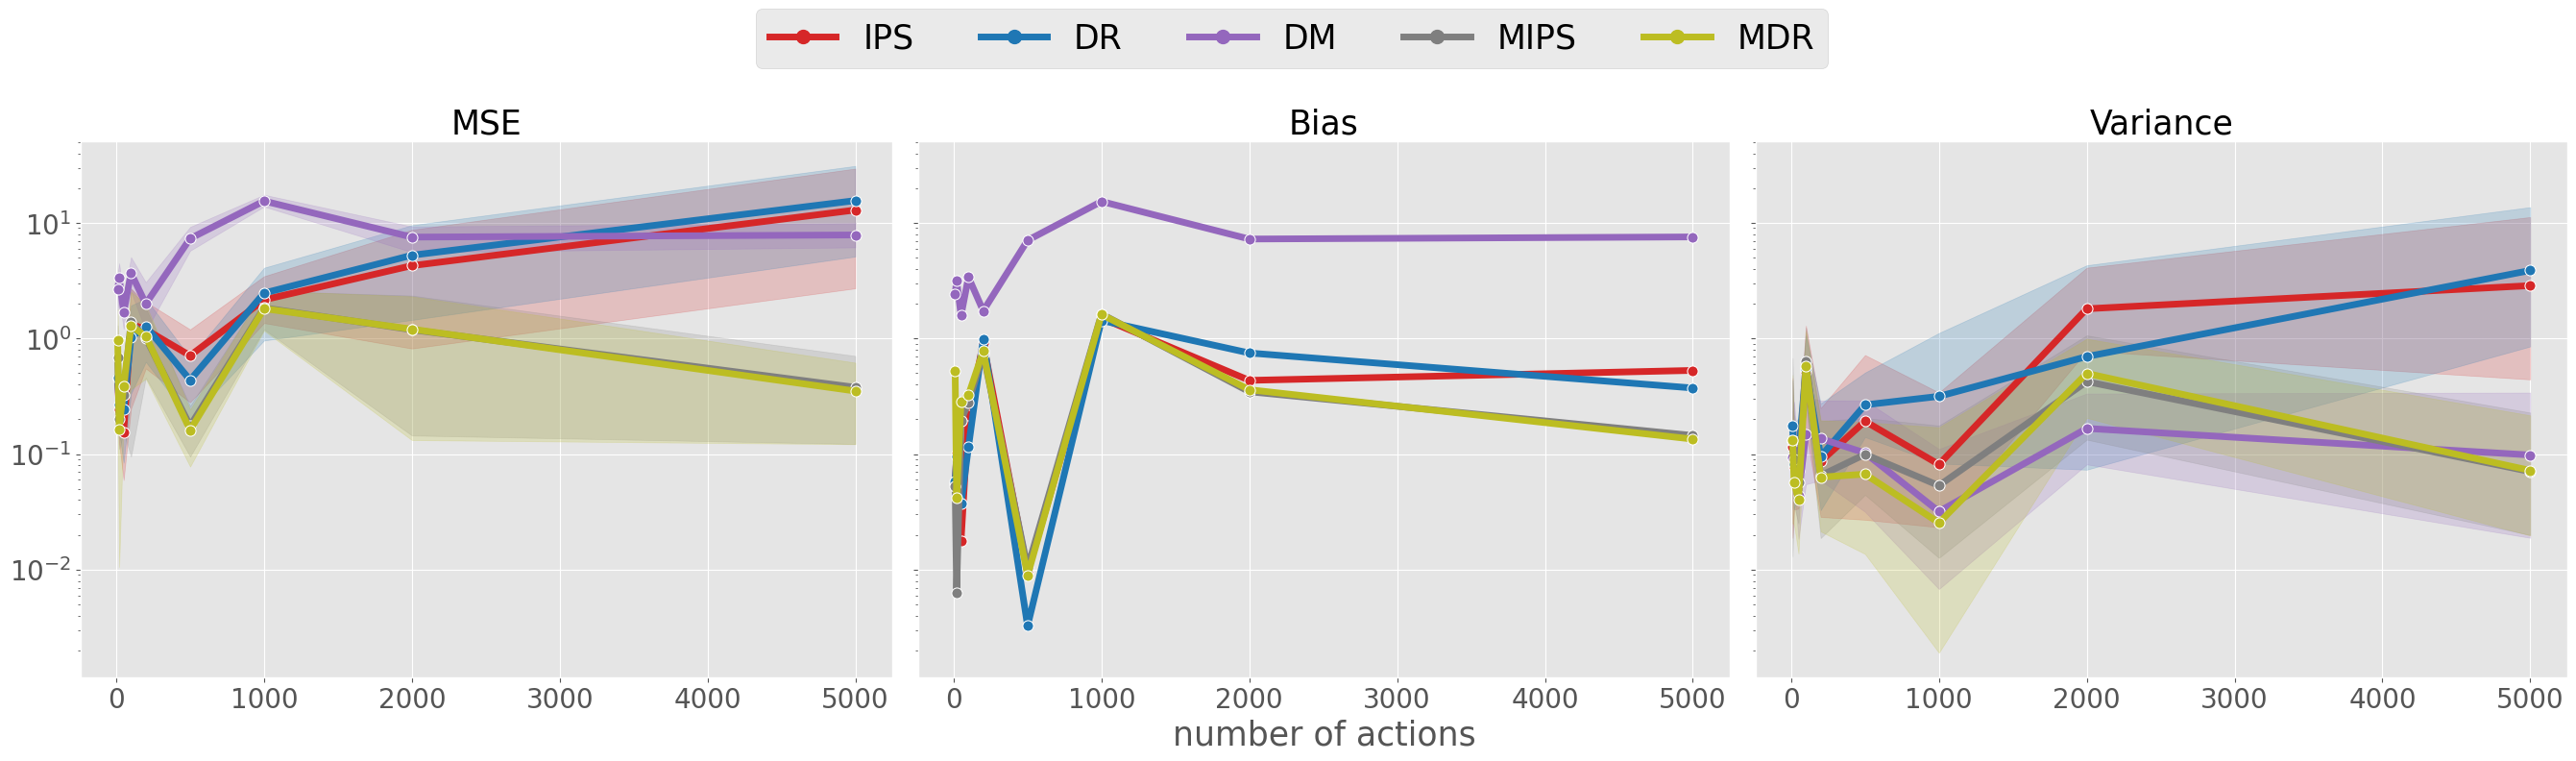

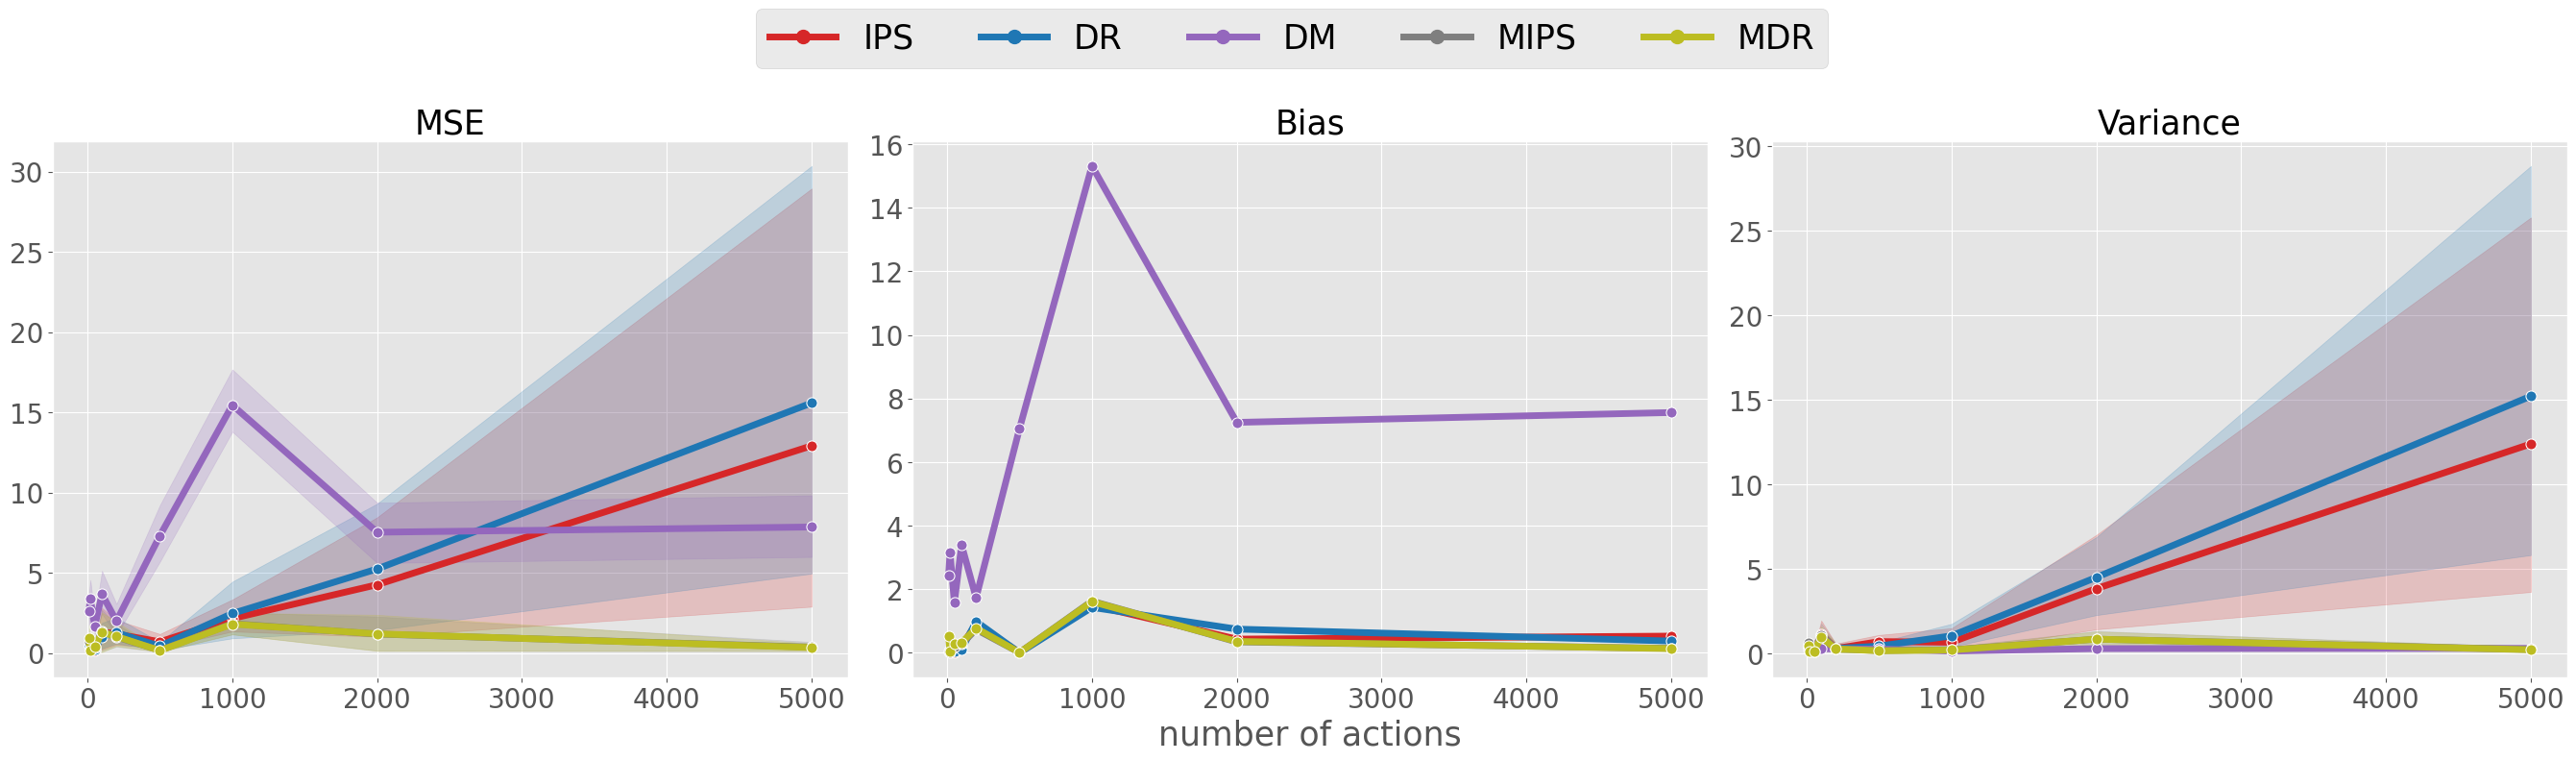

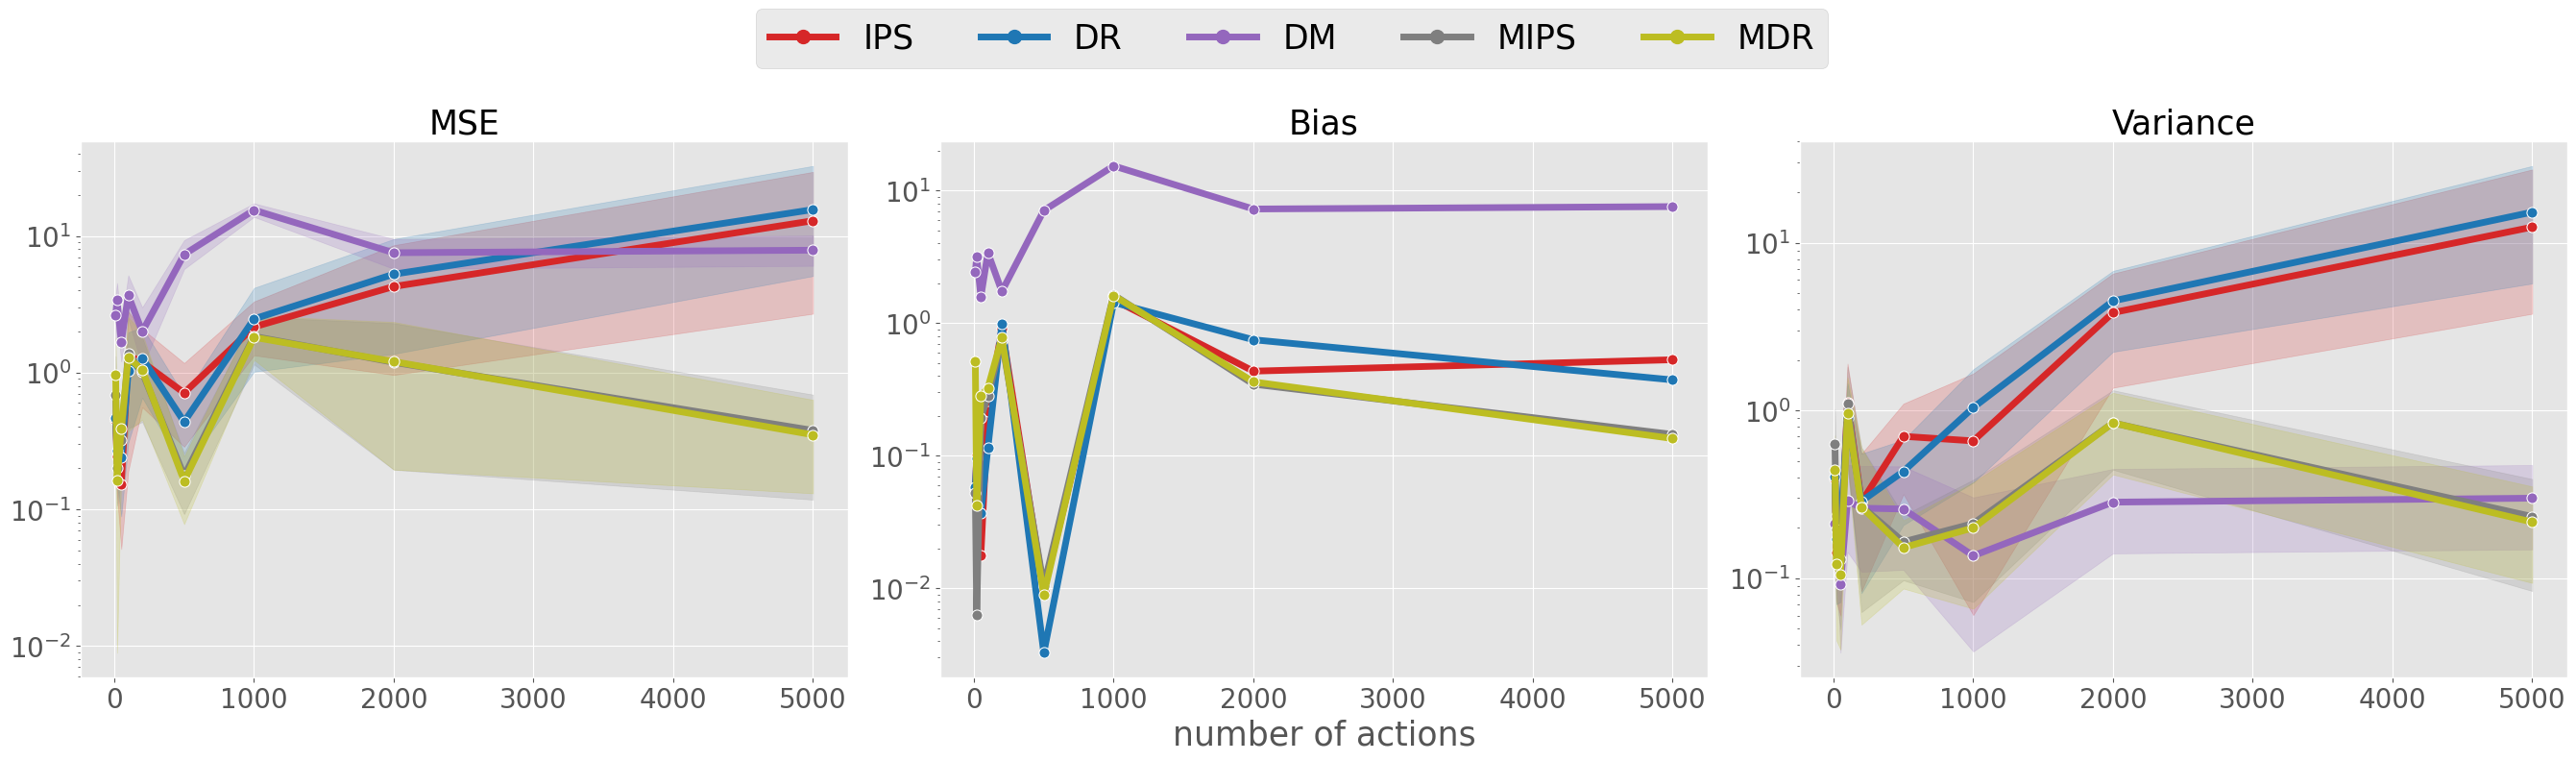

In [81]:
for flag_share_y_scale in [True, False]:
    for flag_log_scale in [False, True]:
        plot_line(
            result_df = result_df, 
            x = x, 
            xlabel = xlabel, 
            flag_log_scale=flag_log_scale, 
            flag_share_y_scale=flag_share_y_scale,
        )